In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [1]:
import polars as pl
import numpy as np
from datetime import datetime, MINYEAR
from recipies import Ingredients, Recipe
from recipies.selector import all_numeric_predictors, all_predictors

# Set up random state for reproducible results
rand_state = np.random.RandomState(42)

# Create time columns for two different groups
timecolumn = pl.concat([
  pl.datetime_range(datetime(MINYEAR, 1, 1, 0), datetime(MINYEAR, 1, 1, 5), "1h", eager=True),
  pl.datetime_range(datetime(MINYEAR, 1, 1, 0), datetime(MINYEAR, 1, 1, 3), "1h", eager=True)
])

# Create sample DataFrame
df = pl.DataFrame({
  "id": [1] * 6 + [2] * 4,
  "time": timecolumn,
  "y": rand_state.normal(size=(10,)),
  "x1": rand_state.normal(loc=10, scale=5, size=(10,)),
  "x2": rand_state.binomial(n=1, p=0.3, size=(10,)),
  "x3": pl.Series(["a", "b", "c", "a", "c", "b", "c", "a", "b", "c"], dtype=pl.Categorical),
  "x4": pl.Series(["x", "y", "y", "x", "y", "y", "x", "x", "y", "x"], dtype=pl.Categorical),
})

# Introduce some missing values
df = df.with_columns(
  pl.when(pl.int_range(pl.len()).is_in([1, 2, 4, 7]))
  .then(None)
  .otherwise(pl.col("x1"))
  .alias("x1")
)

# Create Ingredients and Recipe
ing = Ingredients(df)
rec = Recipe(
  ing,
  outcomes=["y"],
  predictors=["x1", "x2", "x3", "x4"],
  groups=["id"],
  sequences=["time"]
)
rec.add_step(StepSklearn(MissingIndicator(features="all"), sel=all_predictors()))
rec.add_step("impute", "x1", method="mean")
rec.add_step(StepHistorical(sel=all_predictors(), fun=Accumulator.MEAN, suffix="mean_hist"))

# Apply the recipe to the ingredients
df = rec.prep()
df2 = df.copy()
# Apply the recipe to a new DataFrame (e.g., test set)
df2 = rec.bake(df2)

ModuleNotFoundError: No module named 'recipies'

In [47]:
# Load the benchmark results
results = pd.read_csv("/Users/robin/Downloads/results_datasizes_[50, 100, 1000, 10000, 100000, 1000000]_seeds_[1, 2, 3, 4, 5]_datetime_2025-07-09_12-27-28.csv")


In [72]:
# Filter to only include steps containing "Historical"
results = results[results["step"].str.contains("Historical", case=False, na=False)]


In [73]:
print(f"Filtered dataset shape: {results.shape}")
print(f"Steps after filtering: {results['step'].unique()}")
print(results)

Filtered dataset shape: (24, 12)
Steps after filtering: ['Historical_Count' 'Historical_Max' 'Historical_Mean' 'Historical_Min']
    data_size              step  duration_mean_Polars  duration_mean_Pandas  \
0          50  Historical_Count               13551.2               34835.6   
1          50    Historical_Max               12118.4               27485.2   
2          50   Historical_Mean               23535.4               59760.4   
3          50    Historical_Min               16364.2               28650.0   
14        100  Historical_Count               12786.4               35684.4   
15        100    Historical_Max               12219.0               27543.8   
16        100   Historical_Mean               10600.0               38117.4   
17        100    Historical_Min               11431.4               27839.6   
28       1000  Historical_Count               14541.6               70149.6   
29       1000    Historical_Max               15511.8               32114.0   
30

In [74]:
# Display basic info about the dataset
print("Dataset shape:", results.shape)
print("\nColumn names:")
print(results.columns.tolist())
print("\nFirst few rows:")
print(results.head())
print("\nUnique data sizes:", sorted(results['data_size'].unique()))
print("\nUnique steps:", results['step'].unique())


Dataset shape: (24, 12)

Column names:
['data_size', 'step', 'duration_mean_Polars', 'duration_mean_Pandas', 'duration_std_Polars', 'duration_std_Pandas', 'memory_mean_Polars', 'memory_mean_Pandas', 'memory_std_Polars', 'memory_std_Pandas', 'speed_difference', 'speedup']

First few rows:
    data_size              step  duration_mean_Polars  duration_mean_Pandas  \
0          50  Historical_Count               13551.2               34835.6   
1          50    Historical_Max               12118.4               27485.2   
2          50   Historical_Mean               23535.4               59760.4   
3          50    Historical_Min               16364.2               28650.0   
14        100  Historical_Count               12786.4               35684.4   

    duration_std_Polars  duration_std_Pandas  memory_mean_Polars  \
0                4806.7                723.8               227.7   
1                3595.6                673.7               227.7   
2               31728.9         

In [75]:
# Aggregate performance by data size (across all steps)
# Since your data is already aggregated by step, we'll aggregate further by data_size

summary = results.groupby('data_size').agg({
    'duration_mean_Polars': 'mean',
    'duration_mean_Pandas': 'mean',
    'duration_std_Polars': 'mean',
    'duration_std_Pandas': 'mean',
    'memory_mean_Polars': 'mean',
    'memory_mean_Pandas': 'mean',
    'memory_std_Polars': 'mean',
    'memory_std_Pandas': 'mean',
    'speedup': 'mean'
}).round(4)

# Reset index to make data_size a column
summary = summary.reset_index()

print("Aggregated Performance by Data Size:")
print(summary)


Aggregated Performance by Data Size:
   data_size  duration_mean_Polars  duration_mean_Pandas  duration_std_Polars  \
0         50              16392.30              37682.80            13828.450   
1        100              11759.20              32296.30             2207.300   
2       1000              14426.65              50827.75             1060.225   
3      10000              48387.35             259684.55             2624.025   
4     100000             254130.50            2063626.40            13206.375   
5    1000000            1972222.70           19710543.65            64297.175   

   duration_std_Pandas  memory_mean_Polars  memory_mean_Pandas  \
0             14614.05             227.700             233.400   
1              1833.35             247.300             247.800   
2               651.20             304.950             315.700   
3             19314.15             453.775             449.600   
4             24738.15            1776.400            2053.425   

In [76]:
# Calculate additional performance metrics
summary['duration_ratio_pandas_vs_polars'] = (summary['duration_mean_Pandas'] / summary['duration_mean_Polars']).round(2)
summary['memory_ratio_pandas_vs_polars'] = (summary['memory_mean_Pandas'] / summary['memory_mean_Polars']).round(2)

# Calculate coefficient of variation for each backend
summary['duration_cv_polars'] = (summary['duration_std_Polars'] / summary['duration_mean_Polars'] * 100).round(2)
summary['duration_cv_pandas'] = (summary['duration_std_Pandas'] / summary['duration_mean_Pandas'] * 100).round(2)
summary['memory_cv_polars'] = (summary['memory_std_Polars'] / summary['memory_mean_Polars'] * 100).round(2)
summary['memory_cv_pandas'] = (summary['memory_std_Pandas'] / summary['memory_mean_Pandas'] * 100).round(2)

print("\nEnhanced Performance Summary:")
print(summary[['data_size', 'duration_ratio_pandas_vs_polars', 'memory_ratio_pandas_vs_polars',
               'duration_cv_polars', 'duration_cv_pandas', 'memory_cv_polars', 'memory_cv_pandas']])



Enhanced Performance Summary:
   data_size  duration_ratio_pandas_vs_polars  memory_ratio_pandas_vs_polars  \
0         50                             2.30                           1.03   
1        100                             2.75                           1.00   
2       1000                             3.52                           1.04   
3      10000                             5.37                           0.99   
4     100000                             8.12                           1.16   
5    1000000                             9.99                           1.25   

   duration_cv_polars  duration_cv_pandas  memory_cv_polars  memory_cv_pandas  
0               84.36               38.78              5.27              2.23  
1               18.77                5.68              1.13              0.85  
2                7.35                1.28             10.69              7.60  
3                5.42                7.44             10.23              3.09  
4       

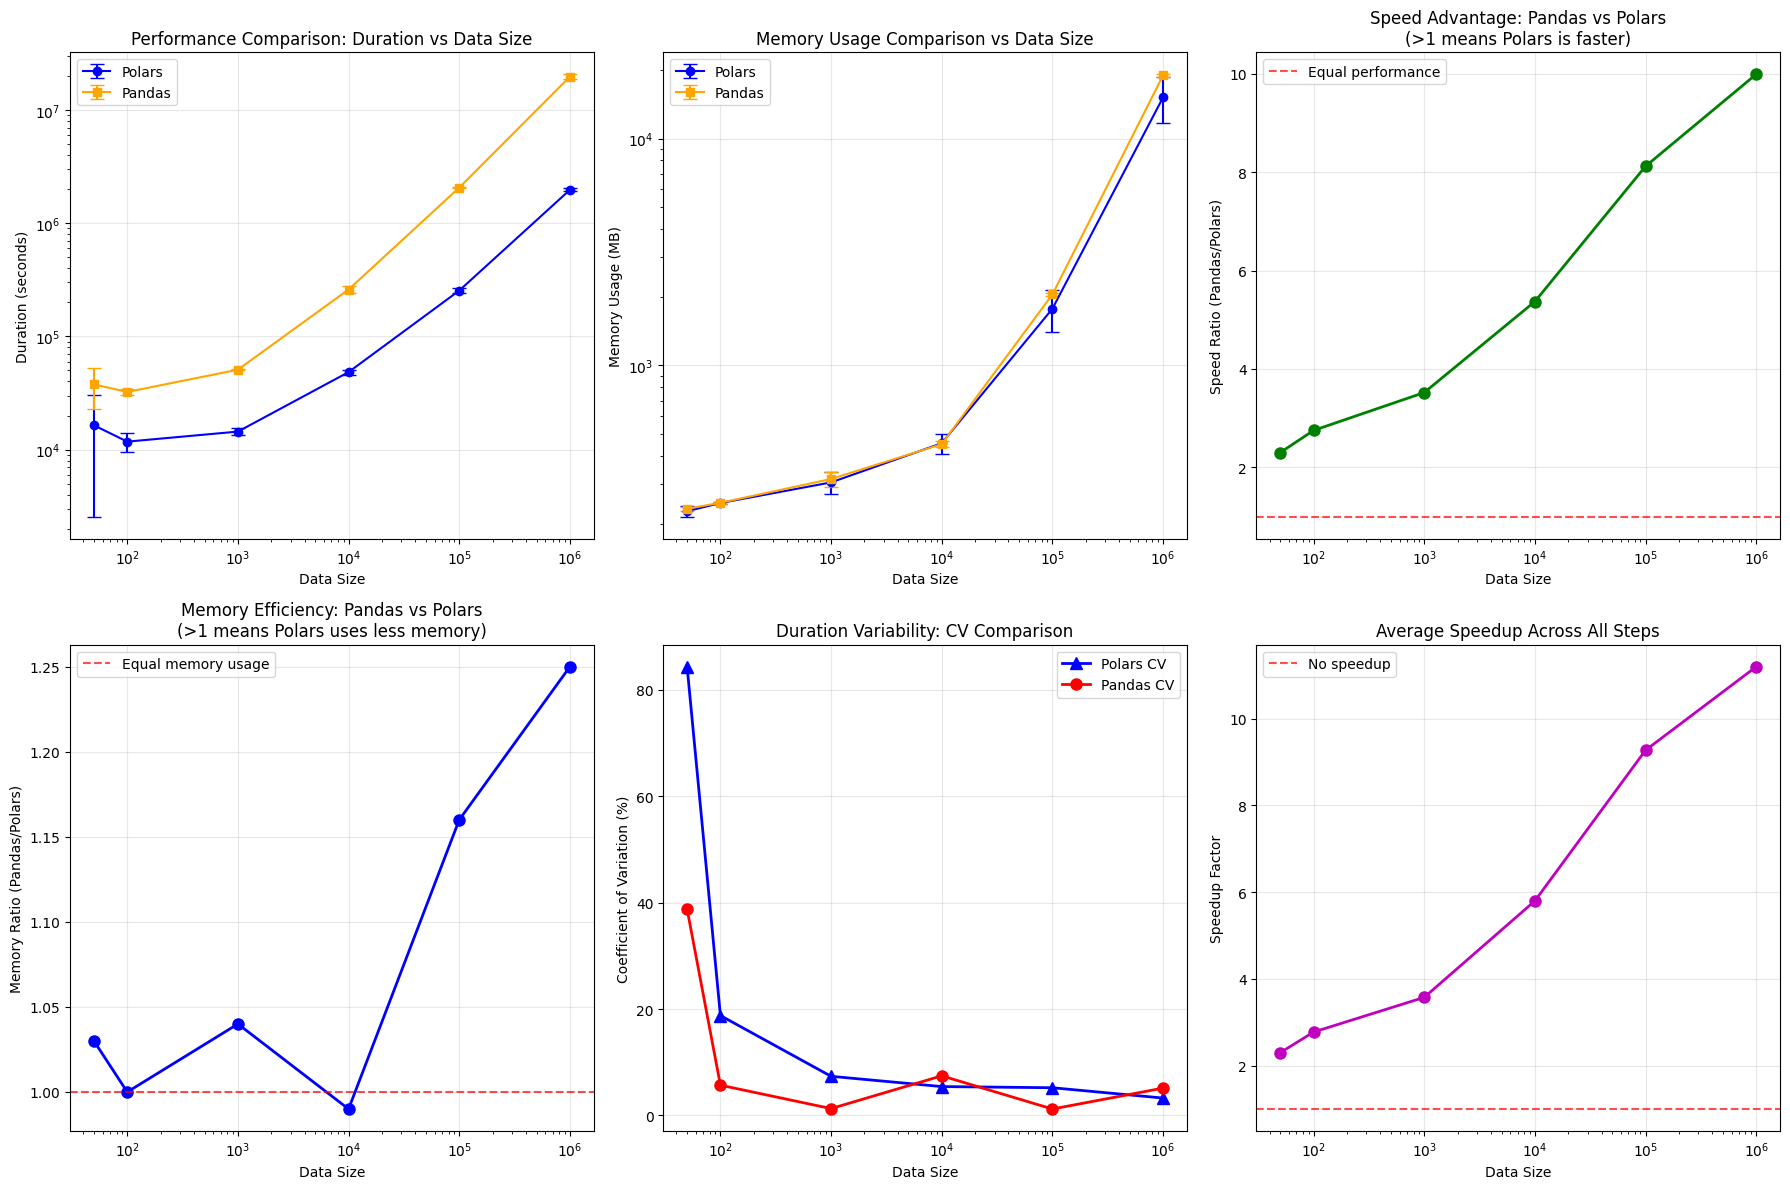

In [77]:
# Create comprehensive visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Duration comparison with error bars
ax1 = axes[0, 0]
ax1.errorbar(summary['data_size'], summary['duration_mean_Polars'],
            yerr=summary['duration_std_Polars'], label='Polars', marker='o', capsize=5, color='blue')
ax1.errorbar(summary['data_size'], summary['duration_mean_Pandas'],
            yerr=summary['duration_std_Pandas'], label='Pandas', marker='s', capsize=5, color='orange')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Data Size')
ax1.set_ylabel('Duration (seconds)')
ax1.set_title('Performance Comparison: Duration vs Data Size')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Memory usage comparison with error bars
ax2 = axes[0, 1]
ax2.errorbar(summary['data_size'], summary['memory_mean_Polars'],
            yerr=summary['memory_std_Polars'], label='Polars', marker='o', capsize=5, color='blue')
ax2.errorbar(summary['data_size'], summary['memory_mean_Pandas'],
            yerr=summary['memory_std_Pandas'], label='Pandas', marker='s', capsize=5, color='orange')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Data Size')
ax2.set_ylabel('Memory Usage (MB)')
ax2.set_title('Memory Usage Comparison vs Data Size')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Speed ratio (Pandas/Polars - higher means Polars is faster)
ax3 = axes[0, 2]
ax3.plot(summary['data_size'], summary['duration_ratio_pandas_vs_polars'],
         'go-', linewidth=2, markersize=8)
ax3.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Equal performance')
ax3.set_xscale('log')
ax3.set_xlabel('Data Size')
ax3.set_ylabel('Speed Ratio (Pandas/Polars)')
ax3.set_title('Speed Advantage: Pandas vs Polars\n(>1 means Polars is faster)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Memory ratio (Pandas/Polars - higher means Polars uses less memory)
ax4 = axes[1, 0]
ax4.plot(summary['data_size'], summary['memory_ratio_pandas_vs_polars'],
         'bo-', linewidth=2, markersize=8)
ax4.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Equal memory usage')
ax4.set_xscale('log')
ax4.set_xlabel('Data Size')
ax4.set_ylabel('Memory Ratio (Pandas/Polars)')
ax4.set_title('Memory Efficiency: Pandas vs Polars\n(>1 means Polars uses less memory)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Coefficient of Variation comparison for Duration
ax5 = axes[1, 1]
ax5.plot(summary['data_size'], summary['duration_cv_polars'],
         'b^-', linewidth=2, markersize=8, label='Polars CV')
ax5.plot(summary['data_size'], summary['duration_cv_pandas'],
         'ro-', linewidth=2, markersize=8, label='Pandas CV')
ax5.set_xscale('log')
ax5.set_xlabel('Data Size')
ax5.set_ylabel('Coefficient of Variation (%)')
ax5.set_title('Duration Variability: CV Comparison')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Speedup over data sizes
ax6 = axes[1, 2]
ax6.plot(summary['data_size'], summary['speedup'],
         'mo-', linewidth=2, markersize=8)
ax6.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='No speedup')
ax6.set_xscale('log')
ax6.set_xlabel('Data Size')
ax6.set_ylabel('Speedup Factor')
ax6.set_title('Average Speedup Across All Steps')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [78]:
# Create a detailed summary report
print("="*100)
print("COMPREHENSIVE BENCHMARK RESULTS SUMMARY")
print("="*100)

for _, row in summary.iterrows():
    data_size = int(row['data_size'])
    print(f"\nData Size: {data_size:,} rows")
    print("-" * 60)

    # Duration results
    polars_duration = row['duration_mean_Polars']
    pandas_duration = row['duration_mean_Pandas']
    polars_duration_std = row['duration_std_Polars']
    pandas_duration_std = row['duration_std_Pandas']
    duration_ratio = row['duration_ratio_pandas_vs_polars']

    print("PERFORMANCE (Duration):")
    print(f"  Polars:  {polars_duration:.4f} ± {polars_duration_std:.4f} seconds (CV: {row['duration_cv_polars']:.1f}%)")
    print(f"  Pandas:  {pandas_duration:.4f} ± {pandas_duration_std:.4f} seconds (CV: {row['duration_cv_pandas']:.1f}%)")
    print(f"  Ratio:   {duration_ratio:.2f}x ({'Polars faster' if duration_ratio > 1 else 'Pandas faster'})")

    # Memory results
    polars_memory = row['memory_mean_Polars']
    pandas_memory = row['memory_mean_Pandas']
    polars_memory_std = row['memory_std_Polars']
    pandas_memory_std = row['memory_std_Pandas']
    memory_ratio = row['memory_ratio_pandas_vs_polars']

    print("\nMEMORY USAGE:")
    print(f"  Polars:  {polars_memory:.2f} ± {polars_memory_std:.2f} MB (CV: {row['memory_cv_polars']:.1f}%)")
    print(f"  Pandas:  {pandas_memory:.2f} ± {pandas_memory_std:.2f} MB (CV: {row['memory_cv_pandas']:.1f}%)")
    print(f"  Ratio:   {memory_ratio:.2f}x ({'Polars more efficient' if memory_ratio > 1 else 'Pandas more efficient'})")

    # Overall speedup
    speedup = row['speedup']
    print(f"\nOVERALL SPEEDUP: {speedup:.2f}x")


COMPREHENSIVE BENCHMARK RESULTS SUMMARY

Data Size: 50 rows
------------------------------------------------------------
PERFORMANCE (Duration):
  Polars:  16392.3000 ± 13828.4500 seconds (CV: 84.4%)
  Pandas:  37682.8000 ± 14614.0500 seconds (CV: 38.8%)
  Ratio:   2.30x (Polars faster)

MEMORY USAGE:
  Polars:  227.70 ± 12.00 MB (CV: 5.3%)
  Pandas:  233.40 ± 5.20 MB (CV: 2.2%)
  Ratio:   1.03x (Polars more efficient)

OVERALL SPEEDUP: 2.30x

Data Size: 100 rows
------------------------------------------------------------
PERFORMANCE (Duration):
  Polars:  11759.2000 ± 2207.3000 seconds (CV: 18.8%)
  Pandas:  32296.3000 ± 1833.3500 seconds (CV: 5.7%)
  Ratio:   2.75x (Polars faster)

MEMORY USAGE:
  Polars:  247.30 ± 2.80 MB (CV: 1.1%)
  Pandas:  247.80 ± 2.10 MB (CV: 0.8%)
  Ratio:   1.00x (Pandas more efficient)

OVERALL SPEEDUP: 2.77x

Data Size: 1,000 rows
------------------------------------------------------------
PERFORMANCE (Duration):
  Polars:  14426.6500 ± 1060.2250 seconds

In [79]:
# Performance by step analysis
print("\n" + "="*100)
print("PERFORMANCE BY STEP ANALYSIS")
print("="*100)

step_analysis = results.groupby('step').agg({
    'duration_mean_Polars': 'mean',
    'duration_mean_Pandas': 'mean',
    'memory_mean_Polars': 'mean',
    'memory_mean_Pandas': 'mean',
    'speedup': 'mean'
}).round(4)

step_analysis['duration_ratio'] = (step_analysis['duration_mean_Pandas'] / step_analysis['duration_mean_Polars']).round(2)
step_analysis['memory_ratio'] = (step_analysis['memory_mean_Pandas'] / step_analysis['memory_mean_Polars']).round(2)

print("\nAverage Performance by Step (across all data sizes):")
print(step_analysis)

# Find best and worst performing steps for each backend
print(f"\nFastest steps for Polars: {step_analysis.nsmallest(3, 'duration_mean_Polars').index.tolist()}")
print(f"Fastest steps for Pandas: {step_analysis.nsmallest(3, 'duration_mean_Pandas').index.tolist()}")
print(f"Steps where Polars has biggest advantage: {step_analysis.nlargest(3, 'duration_ratio').index.tolist()}")
print(f"Most memory efficient steps (Polars): {step_analysis.nsmallest(3, 'memory_mean_Polars').index.tolist()}")



PERFORMANCE BY STEP ANALYSIS

Average Performance by Step (across all data sizes):
                  duration_mean_Polars  duration_mean_Pandas  \
step                                                           
Historical_Count           302742.7667          6.949495e+06   
Historical_Max             425691.6000          5.409958e+05   
Historical_Mean            389629.6333          6.727927e+06   
Historical_Min             426815.1333          5.513567e+05   

                  memory_mean_Polars  memory_mean_Pandas  speedup  \
step                                                                
Historical_Count             3034.35           3826.4000  10.9167   
Historical_Max               3033.90           3621.8500   1.7833   
Historical_Mean              3026.15           3781.7333   8.8333   
Historical_Min               3028.55           3614.9333   1.7500   

                  duration_ratio  memory_ratio  
step                                            
Historical_Count  

In [80]:
# Export results to CSV files
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')

# Export aggregated summary by data size
summary_file = f"performance_summary_by_datasize_{timestamp}.csv"
summary.to_csv(summary_file, index=False)
print(f"\nData size performance summary exported to: {summary_file}")

# Export step analysis
step_file = f"performance_summary_by_step_{timestamp}.csv"
step_analysis.to_csv(step_file, index=True)
print(f"Step performance summary exported to: {step_file}")

# Export detailed comparison table
comparison_df = summary[['data_size', 'duration_ratio_pandas_vs_polars', 'memory_ratio_pandas_vs_polars', 'speedup']].copy()
comparison_df.columns = ['data_size', 'speed_ratio_pandas_vs_polars', 'memory_ratio_pandas_vs_polars', 'speedup']
comparison_file = f"performance_comparison_{timestamp}.csv"
comparison_df.to_csv(comparison_file, index=False)
print(f"Performance comparison exported to: {comparison_file}")



Data size performance summary exported to: performance_summary_by_datasize_20250723_155307.csv
Step performance summary exported to: performance_summary_by_step_20250723_155307.csv
Performance comparison exported to: performance_comparison_20250723_155307.csv


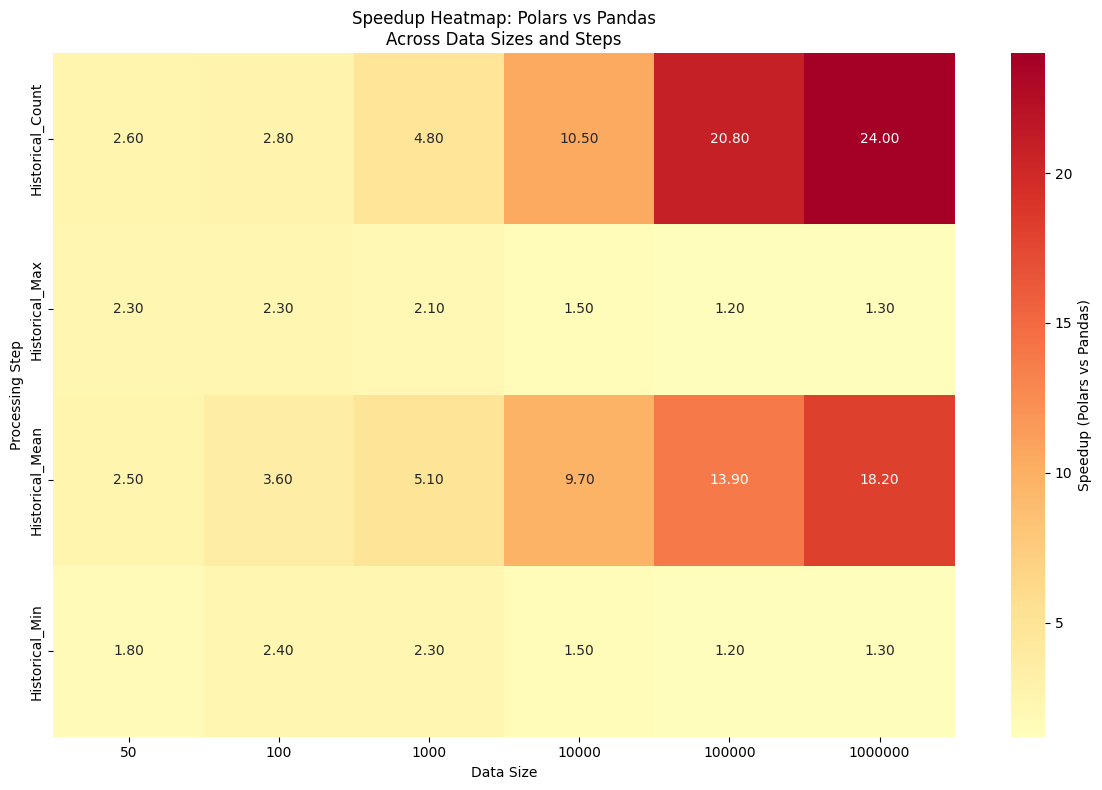

In [81]:
# Create a heatmap showing performance across data sizes and steps
plt.figure(figsize=(12, 8))

# Pivot the data to create a matrix for heatmap
duration_heatmap_data = results.pivot(index='step', columns='data_size', values='speedup')

# Create heatmap
sns.heatmap(duration_heatmap_data, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=1, cbar_kws={'label': 'Speedup (Polars vs Pandas)'})
plt.title('Speedup Heatmap: Polars vs Pandas\nAcross Data Sizes and Steps')
plt.xlabel('Data Size')
plt.ylabel('Processing Step')
plt.tight_layout()
plt.show()


In [82]:
# Summary statistics
print("\n" + "="*80)
print("OVERALL BENCHMARK STATISTICS")
print("="*80)

print(f"Data sizes tested: {len(summary)} ({min(summary['data_size']):,} to {max(summary['data_size']):,} rows)")
print(f"Processing steps analyzed: {len(step_analysis)}")
print(f"Total benchmark combinations: {len(results)}")

print(f"\nOverall Performance Summary:")
print(f"Average speedup across all tests: {results['speedup'].mean():.2f}x")
print(f"Best speedup achieved: {results['speedup'].max():.2f}x")
print(f"Worst speedup: {results['speedup'].min():.2f}x")

print(f"\nDuration Performance:")
print(f"Average Polars duration: {summary['duration_mean_Polars'].mean():.4f} seconds")
print(f"Average Pandas duration: {summary['duration_mean_Pandas'].mean():.4f} seconds")
print(f"Overall speed ratio: {(summary['duration_mean_Pandas'].mean() / summary['duration_mean_Polars'].mean()):.2f}x")

print(f"\nMemory Performance:")
print(f"Average Polars memory: {summary['memory_mean_Polars'].mean():.2f} MB")
print(f"Average Pandas memory: {summary['memory_mean_Pandas'].mean():.2f} MB")
print(f"Overall memory ratio: {(summary['memory_mean_Pandas'].mean() / summary['memory_mean_Polars'].mean()):.2f}x")



OVERALL BENCHMARK STATISTICS
Data sizes tested: 6 (50 to 1,000,000 rows)
Processing steps analyzed: 4
Total benchmark combinations: 24

Overall Performance Summary:
Average speedup across all tests: 5.82x
Best speedup achieved: 24.00x
Worst speedup: 1.20x

Duration Performance:
Average Polars duration: 386219.7833 seconds
Average Pandas duration: 3692443.5750 seconds
Overall speed ratio: 9.56x

Memory Performance:
Average Polars memory: 3030.74 MB
Average Pandas memory: 3711.23 MB
Overall memory ratio: 1.22x
